# Performing measurements using QCoDeS parameters and DataSet

This notebook shows some ways of performing different measurements using 
QCoDeS parameters and the [DataSet](DataSet-class-walkthrough.ipynb) via a powerful ``Measurement`` context manager. Here, it is assumed that the reader has some degree of familiarity with fundamental objects and methods of QCoDeS.

## Implementing a measurement

Now, let us start with necessary imports:

In [1]:
%matplotlib inline
import numpy.random as rd
import matplotlib.pyplot as plt
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station, load_or_create_experiment, \
    initialise_database, Measurement, load_by_run_spec, load_by_guid
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement

qc.logger.start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210326-5721-qcodes.log


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210326-5721-qcodes.log


In what follows, we shall define some utility functions as well as declare our dummy instruments. We, then, add these instruments to a ``Station`` object. 

The dummy dmm is setup to generate an output depending on the values set on the dummy dac simulating a real experiment.

In [2]:
# preparatory mocking of physical setup

dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement(name='dmm', setter_instr=dac)

station = qc.Station(dmm, dac)

In [3]:
# now make some silly set-up and tear-down actions

def veryfirst():
    print('Starting the measurement')

def numbertwo(inst1, inst2):
    print('Doing stuff with the following two instruments: {}, {}'.format(inst1, inst2))
    
def thelast():
    print('End of experiment')

**Note** that database and experiments may be missing.

If this is the first time you create a dataset, the underlying database file has
most likely not been created. The following cell creates the database file. Please
refer to documentation on [`The Experiment Container`](The-Experiment-Container.ipynb) for details.

Furthermore, datasets are associated to an experiment. By default, a dataset (or "run")
is appended to the latest existing experiments. If no experiment has been created,
we must create one. We do that by calling the `load_or_create_experiment` function.

Here we explicitly pass the loaded or created experiment to the `Measurement` object to ensure that we are always
using the `performing_meas_using_parameters_and_dataset` `Experiment` created within this tutorial.

In [4]:
initialise_database()
exp = load_or_create_experiment(
    experiment_name='performing_meas_using_parameters_and_dataset',
    sample_name="no sample"
)

And then run an experiment:

In [5]:
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

meas.add_before_run(veryfirst, ())  # add a set-up action
meas.add_before_run(numbertwo, (dmm, dac))  # add another set-up action
meas.add_after_run(thelast, ())  # add a tear-down action

meas.write_period = 0.5

with meas.run() as datasaver:             
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    
    dataset = datasaver.dataset  # convenient to have for data access and plotting

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrumentWithMeasurement: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 33. 
End of experiment


In [6]:
dataset1D = dataset  # we'll need this dataset in further sections

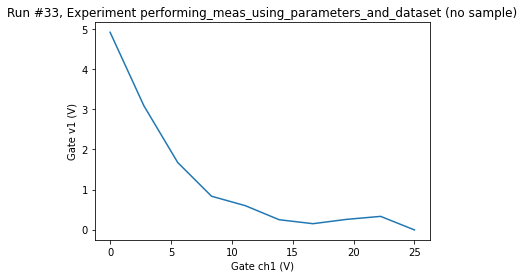

In [7]:
ax, cbax = plot_dataset(dataset1D)

And let's add an example of a 2D measurement. For the 2D, we'll need a new batch of parameters, notably one with two 
other parameters as setpoints. We therefore define a new Measurement with new parameters.

In [8]:
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone

In [9]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 1, 200):
        for v2 in np.linspace(-1, 1, 200):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))
            
    dataset2D = datasaver.dataset

Starting experimental run with id: 34. 


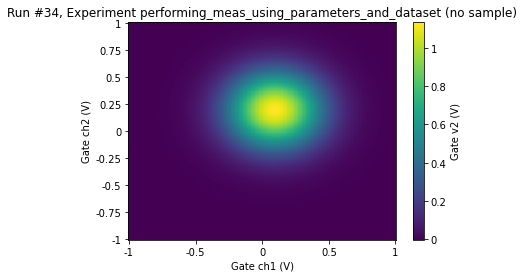

In [10]:
ax, cbax = plot_dataset(dataset2D)

## Accessing and exporting the measured data

QCoDeS ``DataSet`` implements a number of methods for accessing the data of a given dataset. Here we will concentrate on the two most user friendly methods. For a more detailed walkthrough of the `DataSet` class, refer to [DataSet class walkthrough](DataSet-class-walkthrough.ipynb) notebook.

The method `get_parameter_data` returns the data as a dictionary of ``numpy`` arrays. The dictionary is indexed by the measured (dependent) parameter in the outermost level and the names of the dependent and independent parameters in the innermost level. The first parameter in the innermost level is always the dependent parameter.

In [11]:
dataset1D.get_parameter_data()

{'dmm_v1': {'dmm_v1': array([ 4.93005564,  3.09208572,  1.67459962,  0.83219681,  0.59531399,
          0.24476058,  0.14569131,  0.25416028,  0.32838948, -0.00993248]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

By default `get_parameter_data` returns all data stored in the dataset. The data that is specific to one or more measured parameters can be returned by passing the parameter name(s) or by using `ParamSpec` object:

In [12]:
dataset1D.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([ 4.93005564,  3.09208572,  1.67459962,  0.83219681,  0.59531399,
          0.24476058,  0.14569131,  0.25416028,  0.32838948, -0.00993248]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

You can also simply fetch the data for one or more dependent parameter

In [13]:
dataset1D.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

For more details about accessing data of a given `DataSet`, see [Accessing data in DataSet notebook](Accessing-data-in-DataSet.ipynb).

The data can also be exported as one or more [Pandas](https://pandas.pydata.org/) DataFrames. 
The DataFrames cane be returned either as a single dataframe or as a dictionary from measured parameters to DataFrames.
If you measure all parameters as a function of the same set of parameters you probably want to export to a single dataframe.

In [14]:
dataset1D.to_pandas_dataframe()

,dmm_v1
dac_ch1,
0.000000,4.930056
2.777778,3.092086
5.555556,1.674600
8.333333,0.832197
11.111111,0.595314
13.888889,0.244761
16.666667,0.145691
19.444444,0.254160
22.222222,0.328389


However, there may be cases where the data within a dataset cannot be put into a single dataframe. 
In those cases you can use the other method to export the dataset to a dictionary from name of the measured parameter to Pandas dataframes.

In [15]:
dataset1D.to_pandas_dataframe_dict()

{'dmm_v1':              dmm_v1
 dac_ch1            
 0.000000   4.930056
 2.777778   3.092086
 5.555556   1.674600
 8.333333   0.832197
 11.111111  0.595314
 13.888889  0.244761
 16.666667  0.145691
 19.444444  0.254160
 22.222222  0.328389
 25.000000 -0.009932}

When exporting a two or higher dimensional datasets as a Pandas DataFrame a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) is used to index the measured parameter based on all the dependencies

In [16]:
dataset2D.to_pandas_dataframe()[0:10]

dmm_v2
dac_ch1 dac_ch2            
-1.0    -1.000000 -0.000757
        -0.989950  0.000047
        -0.979899  0.000692
        -0.969849  0.000703
        -0.959799 -0.000053
        -0.949749  0.000619
        -0.939698 -0.000175
        -0.929648  0.000225
        -0.919598 -0.000966
        -0.909548  0.000031

If your data is on a regular grid it may make sense to view the data as an [XArray](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) Dataset. The dataset can be directly exported to a XArray Dataset.

In [17]:
dataset2D.to_xarray_dataset()

<xarray.Dataset>
Dimensions:  (dac_ch1: 200, dac_ch2: 200)
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.9899 -0.9799 ... 0.9799 0.9899 1.0
  * dac_ch2  (dac_ch2) float64 -1.0 -0.9899 -0.9799 ... 0.9799 0.9899 1.0
Data variables:
    dmm_v2   (dac_ch1, dac_ch2) float64 -0.0007568 4.674e-05 ... 0.000386
Attributes:
    sample_name:          no sample
    exp_name:             performing_meas_using_parameters_and_dataset
    snapshot:             {"station": {"instruments": {"dmm": {"functions": {...
    guid:                 aaaaaaaa-0000-0000-0000-01786ed9acbc
    run_timestamp:        2021-03-26 14:04:22
    completed_timestamp:  2021-03-26 14:04:31
    run_id:               34

Note, however, that XArray is only suited for data that is on a rectangular grid with few or no missing values. If the data does not lie on a grid, all the measured data points will have an unique combination of the two dependent parameters. When exporting to XArray, NaN's will therefore replace all the missing combinations of `dac_ch1` and `dac_ch2` and the data is unlikely to be useful in this format.

For more details about using Pandas and XArray see [Working With Pandas and XArray](./Working-With-Pandas-and-XArray.ipynb)

## Reloading datasets

To load existing datasets QCoDeS provides several functions. The most useful and generic function is called `load_by_run_spec`. 
This function takes one or more pieces of information about a dataset and will either, if the dataset is uniquely identifiable by the information, load the dataset or print information about all the datasets that match the supplied information allowing you to provide more information to uniquely identify the dataset.

Here, we will load a dataset based on the `captured_run_id` printed on the plot above.

In [18]:
dataset1D.captured_run_id

33

In [19]:
loaded_ds = load_by_run_spec(captured_run_id=dataset1D.captured_run_id)

In [20]:
loaded_ds.the_same_dataset_as(dataset1D)

True

As long as you are working within one database file the dataset should be uniquely identified by `captured_run_id`. However, once you mix several datasets from different database files this is likely not unique. See the following section and [Extracting runs from one DB file to another](Extracting-runs-from-one-DB-file-to-another.ipynb) for more information on how to handle this.

### DataSet GUID

Internally each dataset is refereed too by a Globally Unique Identifier (GUID) that ensures that the dataset uniquely identified even if datasets from several databases with potentially identical captured_run_id, experiment and sample names.
A dataset can always be reloaded from the GUID if known. 

In [21]:
print(f"Dataset GUID is: {dataset1D.guid}")

Dataset GUID is: aaaaaaaa-0000-0000-0000-01786ed9abff


In [22]:
loaded_ds = load_by_guid(dataset1D.guid)

In [23]:
loaded_ds.the_same_dataset_as(dataset1D)

True

## Specifying shape of measurement
As the context manager allows you to store data of any shape (with the only restriction being that you supply values for both dependent and independent parameters together), it cannot know if the data is being measured on a grid. As a consequence, the Numpy array of data loaded from the dataset may not be of the shape that you expect. `plot_dataset`, `DataSet.to_pandas...` and `DataSet.to_xarray...` contain logic that can detect the shape of the data measured at load time. However, if you know the shape of the measurement that you are going to perform up front, you can choose to specify it before initializing the measurement using ``Measurement.set_shapes`` method.

`dataset.get_parameter_data` and `dataset.cache.data` automatically makes use of this information to return shaped data when loaded from the database. Note that these two methods behave slightly different when loading data on a partially completed dataset. `dataset.get_parameter_data` will only reshape the data if the number of points measured matches the number of points expected according to the metadata. `dataset.cache.data` will however return a dataset with empty placeholders (either NaN, zeros or empty strings depending on the datatypes) for missing values in a partially filled dataset. 

Note that if you use the doNd functions demonstrated in [Using doNd functions in comparison to Measurement context manager for performing measurements](Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb) the shape information will be detected and stored automatically.

In the example below we show how the shape can be specified manually.


In [24]:
n_points_1 = 100
n_points_2 = 200

meas_with_shape = Measurement(exp=exp)
meas_with_shape.register_parameter(dac.ch1)  # register the first independent parameter
meas_with_shape.register_parameter(dac.ch2)  # register the second independent parameter
meas_with_shape.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone

meas_with_shape.set_shapes(detect_shape_of_measurement((dmm.v2,), (n_points_1, n_points_2)))

with meas_with_shape.run() as datasaver:

    for v1 in np.linspace(-1, 1, n_points_1):
        for v2 in np.linspace(-1, 1, n_points_2):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))
            
    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 35. 


In [25]:
for name, data in dataset.get_parameter_data()['dmm_v2'].items():
    print(f"{name}: data.shape={data.shape}, expected_shape=({n_points_1},{n_points_2})")
    assert data.shape == (n_points_1, n_points_2)

dmm_v2: data.shape=(100, 200), expected_shape=(100,200)
dac_ch1: data.shape=(100, 200), expected_shape=(100,200)
dac_ch2: data.shape=(100, 200), expected_shape=(100,200)


## Performing several measuments concurrently

It is possible to perform two or more measurements at the same time. This may be convenient if you need to measure several parameters as a function of the same independent parameters.

In [26]:
# setup two measurements
meas1 = Measurement(exp=exp)
meas1.register_parameter(dac.ch1)  
meas1.register_parameter(dac.ch2)  
meas1.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))

meas2 = Measurement(exp=exp)
meas2.register_parameter(dac.ch1)  
meas2.register_parameter(dac.ch2)
meas2.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))

with meas1.run() as datasaver1, meas2.run() as datasaver2:

    v1points = np.concatenate((np.linspace(-2, -0.5, 10),
                               np.linspace(-0.51, 0.5, 200),
                               np.linspace(0.51, 2, 10)))
    v2points = np.concatenate((np.linspace(-2, -0.25, 10),
                               np.linspace(-0.26, 0.5, 200),
                               np.linspace(0.51, 2, 10)))
    
    for v1 in v1points:
        for v2 in v2points:
            dac.ch1(v1)
            dac.ch2(v2)
            val1 = dmm.v1.get()
            datasaver1.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val1))
            val2 = dmm.v2.get()
            datasaver2.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val2))


Starting experimental run with id: 36. 
Starting experimental run with id: 37. 


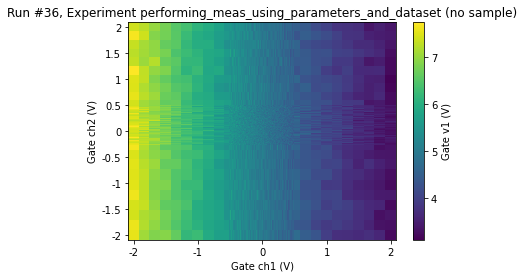

In [27]:
ax, cbax = plot_dataset(datasaver1.dataset)

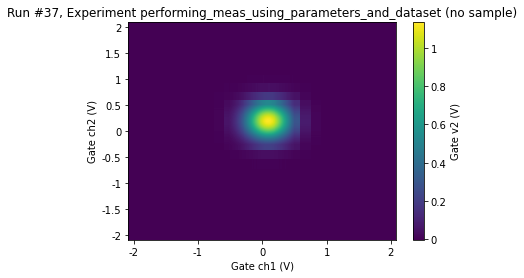

In [28]:
ax, cbax = plot_dataset(datasaver2.dataset)

## Interrupting measurements early

There may be cases where you do not want to complete a measurement. Currently QCoDeS is designed to allow the user
to interrupt the measurements with a standard KeyBoardInterrupt. KeyBoardInterrupts can be raised with either a Ctrl-C keyboard shortcut or using the interrupt button in Juypter / Spyder which is typically in the form of a Square stop button. QCoDeS is designed such that KeyboardInterrupts are delayed around critical parts of the code and the measurement is stopped when its safe to do so. 

## QCoDeS Array and MultiParameter

The ``Measurement`` object supports automatic handling of ``Array`` and ``MultiParameters``. When registering these parameters 
the individual components are unpacked and added to the dataset as if they were separate parameters. Lets consider a ``MultiParamter`` with array components as the most general case.

First lets use a dummy instrument that produces data as ``Array`` and ``MultiParameters``.

In [29]:
from qcodes.tests.instrument_mocks import DummyChannelInstrument

In [30]:
mydummy = DummyChannelInstrument('MyDummy')

This instrument produces two ``Array``s with the names, shapes and setpoints given below.

In [31]:
mydummy.A.dummy_2d_multi_parameter.names

('this', 'that')

In [32]:
mydummy.A.dummy_2d_multi_parameter.shapes

((5, 3), (5, 3))

In [33]:
mydummy.A.dummy_2d_multi_parameter.setpoint_names

(('multi_2d_setpoint_param_this_setpoint',
  'multi_2d_setpoint_param_that_setpoint'),
 ('multi_2d_setpoint_param_this_setpoint',
  'multi_2d_setpoint_param_that_setpoint'))

In [34]:
meas = Measurement(exp=exp)

meas.register_parameter(mydummy.A.dummy_2d_multi_parameter)
meas.parameters

{'MyDummy_ChanA_this': ParamSpecBase('MyDummy_ChanA_this', 'numeric', 'this label', 'this unit'),
 'MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint': ParamSpecBase('MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint', 'numeric', 'this setpoint', 'this setpointunit'),
 'MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint': ParamSpecBase('MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint', 'numeric', 'that setpoint', 'that setpointunit'),
 'MyDummy_ChanA_that': ParamSpecBase('MyDummy_ChanA_that', 'numeric', 'that label', 'that unit')}

When adding the MultiParameter to the measurement we can see that we add each of the individual components as a 
separate parameter.

In [35]:
with meas.run() as datasaver:
    datasaver.add_result((mydummy.A.dummy_2d_multi_parameter, mydummy.A.dummy_2d_multi_parameter()))

Starting experimental run with id: 38. 


And when adding the result of a ``MultiParameter`` it is automatically unpacked into its components.

([<AxesSubplot:title={'center':'Run #38, Experiment performing_meas_using_parameters_and_dataset (no sample)'}, xlabel='this setpoint (this setpointunit)', ylabel='that setpoint (that setpointunit)'>,
  <AxesSubplot:title={'center':'Run #38, Experiment performing_meas_using_parameters_and_dataset (no sample)'}, xlabel='this setpoint (this setpointunit)', ylabel='that setpoint (that setpointunit)'>],
  <matplotlib.colorbar.Colorbar at 0x7f11add58f50>])

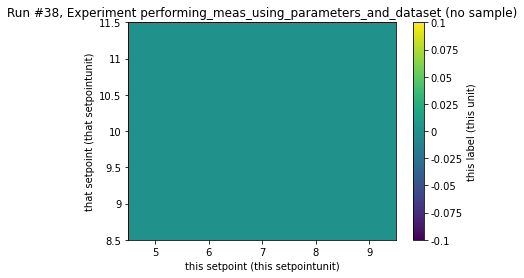

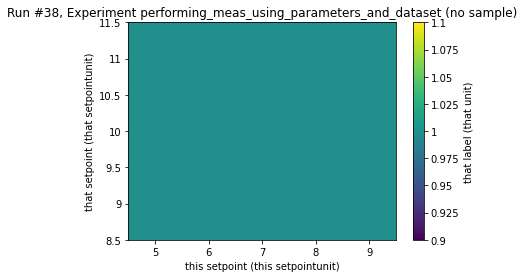

In [36]:
plot_dataset(datasaver.dataset)

In [37]:
datasaver.dataset.get_parameter_data('MyDummy_ChanA_that')

{'MyDummy_ChanA_that': {'MyDummy_ChanA_that': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint': array([5., 5., 5., 6., 6., 6., 7., 7., 7., 8., 8., 8., 9., 9., 9.]),
  'MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint': array([ 9., 10., 11.,  9., 10., 11.,  9., 10., 11.,  9., 10., 11.,  9.,
         10., 11.])}}

In [38]:
datasaver.dataset.to_pandas_dataframe()

MyDummy_ChanA_that  \
MyDummy_ChanA_multi_2d_setpoint_param_this_setp... MyDummy_ChanA_multi_2d_setpoint_param_that_setp...                       
5.0                                                9.0                                                                1.0   
                                                   10.0                                                               1.0   
                                                   11.0                                                               1.0   
6.0                                                9.0                                                                1.0   
                                                   10.0                                                               1.0   
                                                   11.0                                                               1.0   
7.0                                                9.0                                                                1.0   
                                                   10.0                                                               1.0   
                                                   11.0                                                               1.0   
8.0                                                9.0                                                                1.0   
                                                   10.0                                                               1.0   
                                                   11.0                                                               1.0   
9.0                                                9.0                                                                1.0   
                                                   10.0                                                               1.0   
                                                   11.0                                                               1.0   

                                                                                                       MyDummy_ChanA_this  
MyDummy_ChanA_multi_2d_setpoint_param_this_setp... MyDummy_ChanA_multi_2d_setpoint_param_that_setp...                      
5.0                                                9.0                                                                0.0  
                                                   10.0                                                               0.0  
                                                   11.0                                                               0.0  
6.0                                                9.0                                                                0.0  
                                                   10.0                                                               0.0  
                                                   11.0                                                               0.0  
7.0                                                9.0                                                                0.0  
                                                   10.0                                                               0.0  
                                                   11.0                                                               0.0  
8.0                                                9.0                                                                0.0  
                                                   10.0                                                               0.0  
                                                   11.0                                                               0.0  
9.0                                                9.0                                                                0.0  
                                                   10.0                                                              

In [39]:
datasaver.dataset.to_xarray_dataset()

<xarray.Dataset>
Dimensions:                                              (MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint: 3, MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint: 5)
Coordinates:
  * MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint  (MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint) float64 ...
  * MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint  (MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint) float64 ...
Data variables:
    MyDummy_ChanA_that                                   (MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint, MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint) float64 ...
    MyDummy_ChanA_this                                   (MyDummy_ChanA_multi_2d_setpoint_param_this_setpoint, MyDummy_ChanA_multi_2d_setpoint_param_that_setpoint) float64 ...
Attributes:
    sample_name:          no sample
    exp_name:             performing_meas_using_parameters_and_dataset
    snapshot:             {"station": {"instruments": {"dmm": {"functions": {...
    guid:                 aaaaaaaa-0000-0000-0000-01786eda4087
    run_timestamp:        2021-03-26 14:05:00
    completed_timestamp:  2021-03-26 14:05:00
    run_id:               38

## Avoiding verbosity of the Measurement context manager for simple measurements

For simple 1D/2D grid-type of measurements, it may feel like an overkill to use the verbose and flexible Measurement context manager construct. For this case, so-called ``doNd`` functions come ti rescue - convenient one- or two-line calls, read more about them in [Using doNd functions](./Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb).

## Optimizing measurement time

There are measurements that are data-heavy or time consuming, or both. QCoDeS provides some features and tools that should help in optimizing the measurement time. Some of those are:

* [Saving data in the background](./Saving_data_in_the_background.ipynb)
* Setting more appropriate ``paramtype`` when registering parameters, see [Paramtypes explained](./Paramtypes%20explained.ipynb)


## The power of the Measurement context manager construct

This new form is so free that we may easily do thing impossible with the old Loop construct.

Say, that from the plot of the above 1D measurement, 
we decide that a voltage below 1 V is uninteresting,
so we stop the sweep at that point, thus,
we do not know in advance how many points we'll measure.

In [40]:
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

with meas.run() as datasaver:
        
    for set_v in np.linspace(0, 25, 100):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()        
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

        if get_v < 1:
            break
    
    dataset = datasaver.dataset

Starting experimental run with id: 39. 


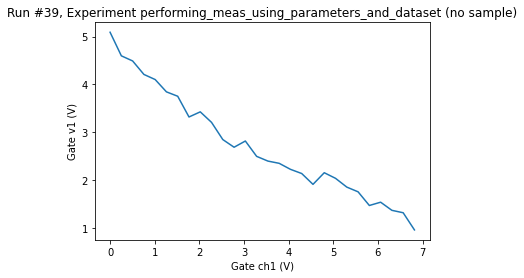

In [41]:
ax, cbax = plot_dataset(dataset)

Or we might want to simply get as many points as possible in 10 s
randomly sampling the region between 0 V and 10 V (for the setpoint axis).

In [42]:
from time import monotonic, sleep

with meas.run() as datasaver:
    
    t_start = monotonic()
    
    while monotonic() - t_start < 3:
        set_v = 10/2*(np.random.rand() + 1)
        dac.ch1.set(set_v)
        
        # some sleep to not get too many points (or to let the system settle)
        sleep(0.04)
        
        get_v = dmm.v1.get()        
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    
    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 40. 


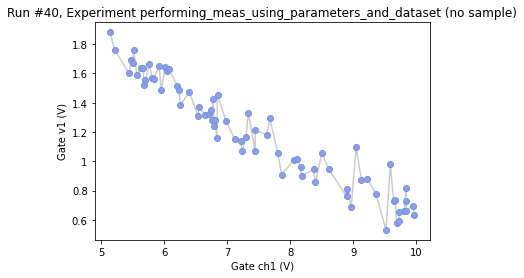

In [43]:
axes, cbax = plot_dataset(dataset)
# we slightly tweak the plot to better visualise the highly non-standard axis spacing
axes[0].lines[0].set_marker('o')
axes[0].lines[0].set_markerfacecolor((0.6, 0.6, 0.9))
axes[0].lines[0].set_markeredgecolor((0.4, 0.6, 0.9))
axes[0].lines[0].set_color((0.8, 0.8, 0.8))

### Finer sampling in 2D

Looking at the plot of the 2D measurement above, we may decide to sample more finely in the central region:

In [44]:
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone

In [45]:
with meas.run() as datasaver:

    v1points = np.concatenate((np.linspace(-1, -0.5, 5),
                               np.linspace(-0.51, 0.5, 200),
                               np.linspace(0.51, 1, 5)))
    v2points = np.concatenate((np.linspace(-1, -0.25, 5),
                               np.linspace(-0.26, 0.5, 200),
                               np.linspace(0.51, 1, 5)))
    
    for v1 in v1points:
        for v2 in v2points:
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))

    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 41. 


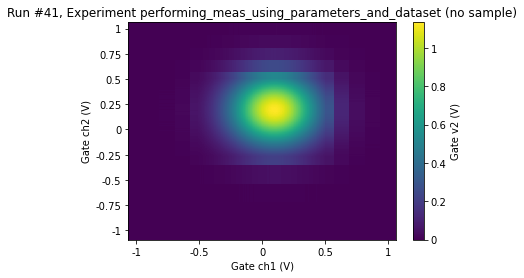

In [46]:
ax, cbax = plot_dataset(dataset)

### Simple adaptive 2D sweep

.. or even perform an adaptive sweep... ooohh...
(the example below is a not-very-clever toy model example,
but it nicely shows a semi-realistic measurement that the old Loop
could not handle)

In [47]:
v1_points = np.linspace(-1, 1, 250)
v2_points = np.linspace(1, -1, 250)

threshold = 0.25

with meas.run() as datasaver:
    # Do normal sweeping until the peak is detected
    
    for v2ind, v2 in enumerate(v2_points):
        for v1ind, v1 in enumerate(v1_points):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))
            if val > threshold:
                break
        else:
            continue
        break
        
    print(v1ind, v2ind, val)
    print('-'*10)
        
    # now be more clever, meandering back and forth over the peak
    doneyet = False
    rowdone = False
    v1_step = 1
    while not doneyet:
            v2 = v2_points[v2ind]
            v1 = v1_points[v1ind+v1_step-1]
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))
            if val < threshold:
                if rowdone:
                    doneyet = True
                v2ind += 1
                v1_step *= -1
                rowdone = True
            else:
                v1ind += v1_step
                rowdone = False
                
dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 42. 


130 46 0.25115823544623594
----------


2021-03-26 14:05:19,654 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ /opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/qcodes/dataset/data_export.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(rows)



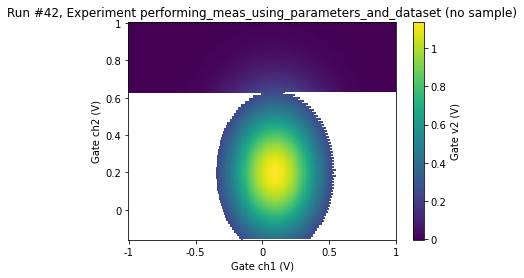

In [48]:
ax, cbax = plot_dataset(dataset)

### Random sampling 

We may also chose to sample completely randomly across the phase space

In [49]:
meas2 = Measurement(exp=exp)
meas2.register_parameter(dac.ch1)  
meas2.register_parameter(dac.ch2)
meas2.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))

threshold = 0.25

npoints = 5000

with meas2.run() as datasaver:
    for i in range(npoints):
        x = 2*(np.random.rand()-.5)
        y = 2*(np.random.rand()-.5)
        dac.ch1(x)
        dac.ch2(y)
        z = dmm.v2()
        datasaver.add_result((dac.ch1, x),
                             (dac.ch2, y),
                             (dmm.v2, z))
dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 43. 


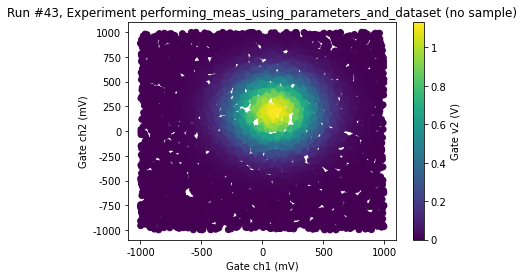

In [50]:
ax, cbax = plot_dataset(dataset)

In [51]:
datasaver.dataset.to_pandas_dataframe()[0:10]

,,dmm_v2
dac_ch1,dac_ch2,
-0.491560,-0.045833,0.043271
-0.790783,0.052463,0.001356
0.535202,0.807697,0.013365
0.197741,-0.833906,-0.000365
0.075310,0.677949,0.182266
-0.708477,-0.800634,0.000079
-0.780150,-0.817095,-0.000591
-0.520838,0.231583,0.051645
0.666170,-0.553366,0.000103


Unlike the data measured above, which lies on a grid, here, all the measured data points have an unique combination of the two dependent parameters. When exporting to XArray NaN's will therefore replace all the missing combinations of `dac_ch1` and `dac_ch2` and the data is unlikely to be useful in this format. 

In [52]:
datasaver.dataset.to_xarray_dataset()

<xarray.Dataset>
Dimensions:  (dac_ch1: 5000, dac_ch2: 5000)
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.9992 -0.9987 ... 0.9982 0.9982 0.9985
  * dac_ch2  (dac_ch2) float64 -0.9996 -0.9992 -0.999 ... 0.9976 0.9985 0.9992
Data variables:
    dmm_v2   (dac_ch1, dac_ch2) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    sample_name:          no sample
    exp_name:             performing_meas_using_parameters_and_dataset
    snapshot:             {"station": {"instruments": {"dmm": {"functions": {...
    guid:                 aaaaaaaa-0000-0000-0000-01786eda8cf8
    run_timestamp:        2021-03-26 14:05:20
    completed_timestamp:  2021-03-26 14:05:20
    run_id:               43

### Optimiser

An example to show that the algorithm is flexible enough to be used with completely unstructured data such as the output of an downhill simplex optimization. The downhill simplex is somewhat more sensitive to noise and it is important that 'fatol' is set to match the expected noise.

In [53]:
from scipy.optimize import minimize

In [54]:
def set_and_measure(*xk):
    dac.ch1(xk[0])
    dac.ch2(xk[1])
    return dmm.v2.get()

noise = 0.0005
x0 = [np.random.rand(), np.random.rand()]

with meas.run() as datasaver:
    def mycallback(xk):
        dac.ch1(xk[0])
        dac.ch2(xk[1])
        datasaver.add_result((dac.ch1, xk[0]),
                             (dac.ch2, xk[1]),
                             (dmm.v2, dmm.v2.cache.get()))
    
    res = minimize(lambda x: -set_and_measure(*x),
                   x0,
                   method='Nelder-Mead',
                   tol=1e-10, 
                   callback=mycallback,
                   options={'fatol': noise})
    
    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 44. 


In [55]:
res

 final_simplex: (array([[0.09632543, 0.20047027],
       [0.09632543, 0.20047027],
       [0.09632543, 0.20047027]]), array([-1.13474126, -1.13429496, -1.13429181]))
           fun: -1.1347412611953103
       message: 'Optimization terminated successfully.'
          nfev: 293
           nit: 105
        status: 0
       success: True
             x: array([0.09632543, 0.20047027])

2021-03-26 14:05:21,723 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ /opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/qcodes/dataset/data_export.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(rows)



2021-03-26 14:05:21,727 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ /opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/qcodes/dataset/data_export.py:131: RuntimeWarning: divide by zero encountered in true_divide
  remainders = np.mod(steps[1:]/steps[0], 1)



2021-03-26 14:05:21,728 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ /opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/qcodes/dataset/data_export.py:131: RuntimeWarning: invalid value encountered in remainder
  remainders = np.mod(steps[1:]/steps[0], 1)



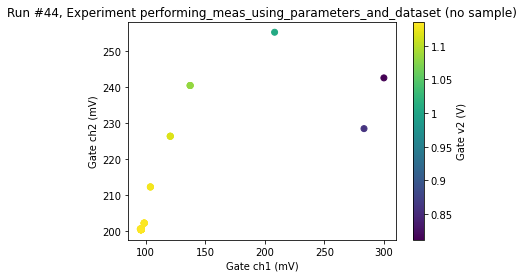

In [56]:
ax, cbax = plot_dataset(dataset)

## Subscriptions

The ``Measurement`` object can also handle subscriptions to the dataset. Subscriptions are, under the hood, triggers in the underlying SQLite database. Therefore, the subscribers are only called when data is written to the database (which happens every `write_period`).

When making a subscription, two things must be supplied: a function and a mutable state object. The function **MUST** have a call signature of `f(result_list, length, state, **kwargs)`, where ``result_list`` is a list of tuples of parameter values inserted in the dataset, ``length`` is an integer (the step number of the run), and ``state`` is the mutable state object. The function does not need to actually use these arguments, but the call signature must match this.

Let us consider two generic examples:

### Subscription example 1: simple printing

In [57]:
def print_which_step(results_list, length, state):
    """
    This subscriber does not use results_list nor state; it simply
    prints how many results we have added to the database
    """
    print(f'The run now holds {length} rows')
    
    
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

meas.write_period = 0.2  # We write to the database every 0.2s

meas.add_subscriber(print_which_step, state=[])

with meas.run() as datasaver:
    for n in range(7):
        datasaver.add_result((dac.ch1, n), (dmm.v1, n**2))
        print(f'Added points to measurement, step {n}.')
        sleep(0.2)

Starting experimental run with id: 45. 
Added points to measurement, step 0.


The run now holds 2 rows
Added points to measurement, step 1.


The run now holds 3 rows
Added points to measurement, step 2.


The run now holds 4 rowsAdded points to measurement, step 3.



The run now holds 5 rows
Added points to measurement, step 4.


The run now holds 6 rows
Added points to measurement, step 5.


The run now holds 7 rowsAdded points to measurement, step 6.



The run now holds 7 rows
The run now holds 7 rows


### Subscription example 2: using the state

We add two subscribers now.

In [58]:
def get_list_of_first_param(results_list, length, state):
    """
    Modify the state (a list) to hold all the values for
    the first parameter
    """
    param_vals = [parvals[0] for parvals in results_list]
    state += param_vals


meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

meas.write_period = 0.2  # We write to the database every 0.2s

first_param_list = []

meas.add_subscriber(print_which_step, state=[])
meas.add_subscriber(get_list_of_first_param, state=first_param_list)

with meas.run() as datasaver:
    for n in range(10):
        datasaver.add_result((dac.ch1, n), (dmm.v1, n**2))
        print(f'Added points to measurement, step {n}.')
        print(f'First parameter value list: {first_param_list}')
        sleep(0.1)

Starting experimental run with id: 46. 
Added points to measurement, step 0.
First parameter value list: []
Added points to measurement, step 1.
First parameter value list: []


The run now holds 3 rows
Added points to measurement, step 2.
First parameter value list: [0, 1, 2]
Added points to measurement, step 3.
First parameter value list: [0, 1, 2]


The run now holds 5 rowsAdded points to measurement, step 4.
First parameter value list: [0, 1, 2]

Added points to measurement, step 5.
First parameter value list: [0, 1, 2, 3, 4]


The run now holds 7 rowsAdded points to measurement, step 6.
First parameter value list: [0, 1, 2, 3, 4, 5, 6]

Added points to measurement, step 7.
First parameter value list: [0, 1, 2, 3, 4, 5, 6]


The run now holds 9 rowsAdded points to measurement, step 8.

First parameter value list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Added points to measurement, step 9.
First parameter value list: [0, 1, 2, 3, 4, 5, 6, 7, 8]


The run now holds 10 rows
The run now holds 10 rows
The run now holds 10 rows
